In [57]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Set some global variables to be used within this notebook

In [58]:
year = "2023" 
points_to_predict = 60

# Load the pre-computed commercial-only dataframe for a specific year specified above

In [59]:
final_df_path = 'data/commercial_df_' + year + '.csv'
final_df = pd.read_csv(final_df_path, sep=',', usecols=['Dew Point Temperature_P39','Power_Consumption', 'Price', 'DateTime'])

In [60]:
final_df['DateTime'] = pd.to_datetime(final_df['DateTime'])
final_df.set_index('DateTime', inplace=True)

In [61]:
final_df.tail(10)

,Power_Consumption,Dew Point Temperature_P39,Price
DateTime,,,
2023-12-31 23:00:00,0.006690,4.8,29.56
2023-12-31 23:00:00,0.000047,4.8,29.56
2023-12-31 23:00:00,0.006792,4.8,29.56
2023-12-31 23:00:00,0.012027,4.8,29.56
2023-12-31 23:00:00,0.001418,4.8,29.56
2023-12-31 23:00:00,0.006591,4.8,29.56
2023-12-31 23:00:00,0.020784,4.8,29.56
2023-12-31 23:00:00,0.000412,4.8,29.56
2023-12-31 23:00:00,0.000028,4.8,29.56


# Agregate data to get all commercial consumption (sum) in Kalmar, mean price and mean temperature per day

In [62]:
# Resample 'Power_Consumption' (sum) and 'Price' (average)
final_df_resampled = final_df.resample('D').agg({'Power_Consumption': 'sum', 'Price': 'mean', 'Dew Point Temperature_P39':'mean'})

In [63]:
final_df_resampled
max_row = final_df_resampled[final_df_resampled.Power_Consumption == final_df_resampled.Power_Consumption.max()]
max_row

,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2023-06-30,421.520976,98.19,14.041667


# Set value to predict

In [64]:
# Resample to every hour, taking mean of values if duplicates
y = final_df_resampled
# Fill NaNs in 'Price' column of df_prophet
y['Price'] = y['Price'].fillna(0)

# Split data into train and predict

In [65]:
y_train, y_test = temporal_train_test_split(y, test_size=points_to_predict)

# Neural network (CNN classifier)  - pure, only previous power consumption, nothing else

In [66]:
# Apply MinMax normalization
scaler = MinMaxScaler(feature_range=(0, 1))
final_df_resampled_scaled = scaler.fit_transform(final_df_resampled)

# Converting to DataFrame
final_df_resampled_scaled = pd.DataFrame(final_df_resampled_scaled, columns=final_df_resampled.columns, index=final_df_resampled.index)

In [67]:
def create_dataset(X, look_back=1):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        v = X.iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(X.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

# Define number of time steps
look_back = 10

# Split the data
train, test = final_df_resampled_scaled.Power_Consumption[:-points_to_predict], final_df_resampled_scaled.Power_Consumption[-points_to_predict:]

# Reshape the data
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [68]:
# Expanding dimension from (samples, time steps) to (samples, time steps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(295, 10, 1)

In [69]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)

In [70]:
# Make predictions
predictions = model.predict(X_test)

# Compute MAE
mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')

2/2 [==============================] - 0s 3ms/step
MAE: 0.04245016011001862


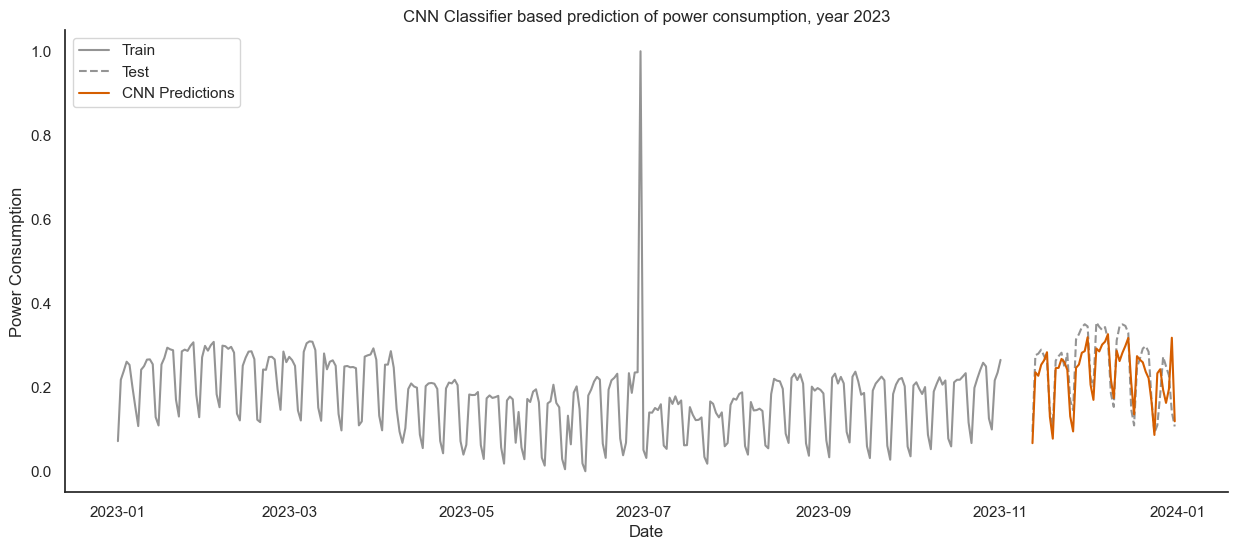

In [102]:
# Initialize Seaborn plot design
sns.set_style("white")

# Create new figure and axis
fig, ax = plt.subplots(figsize=(15,6))

# Convert y_test to pandas series
y_test_pd = pd.Series(y_test.flatten(), index=test.index[look_back:])
predictions = pd.Series(predictions, index=test.index[look_back:])

# "Husl" palette
palette = sns.color_palette('colorblind')

# Plot the training data 
sns.lineplot(x=train.index, y=train, label='Train', ax=ax, color=palette[7])

# Plot the testing data 
sns.lineplot(x=y_test_pd.index, y=y_test_pd, label='Test', ax=ax, color=palette[7], linestyle="--")

# Plot the predictions
sns.lineplot(x=predictions.index, y=predictions, label='CNN Predictions', ax=ax, color=palette[3])

# Turn off the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Setting plot title and labels
ax.set_title('CNN Classifier based prediction of power consumption, year ' + year)
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption')

# Setting legend
ax.legend(loc='upper left')


plt.savefig('figures/CNN_prediction_'+year+'.pdf')
plt.show()


# CNN with modified features - added Price

In [117]:
# Modifieing the create dataset function to have more columns
def create_dataset(df, col1, col2, look_back=1):
    Xs, ys = [], []
    for i in range(len(df) - look_back):
        v = df[[col1, col2]].iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(df[col1].iloc[i + look_back])
    return np.array(Xs), np.array(ys)

In [127]:
# Modify the data split section to include the entire dataframe final_df_resampled_scaled rather than just the Power_Consumption column:
# Split the data
train, test = final_df_resampled_scaled[:-points_to_predict], final_df_resampled_scaled[-points_to_predict:]

# Reshape the data
X_train, y_train = create_dataset(train, 'Power_Consumption', 'Price', look_back)
X_test, y_test = create_dataset(test, 'Power_Consumption', 'Price', look_back)

In [128]:
# Expanding dimension from (samples, time steps) to (samples, time steps, features) is not needed any more!!!!
#X_train = np.expand_dims(X_train, axis=2)
#X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(295, 10, 2)

In [129]:
model = Sequential()
# Here changing the shape of X_train
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [130]:
# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)# Make predictions
predictions = model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


In [131]:
# Compute MAE
mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')

MAE: 0.044786284464083934


In [138]:
train

,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2023-01-01,0.071687,0.149661,0.566585
2023-01-02,0.217834,0.666950,0.597160
2023-01-03,0.238459,0.710856,0.426750
2023-01-04,0.260825,0.402584,0.501811
2023-01-05,0.253179,0.622089,0.398638
...,...,...,...
2023-10-28,0.125751,0.383268,0.536154
2023-10-29,0.099498,0.200967,0.572091
2023-10-30,0.216341,0.343436,0.682655


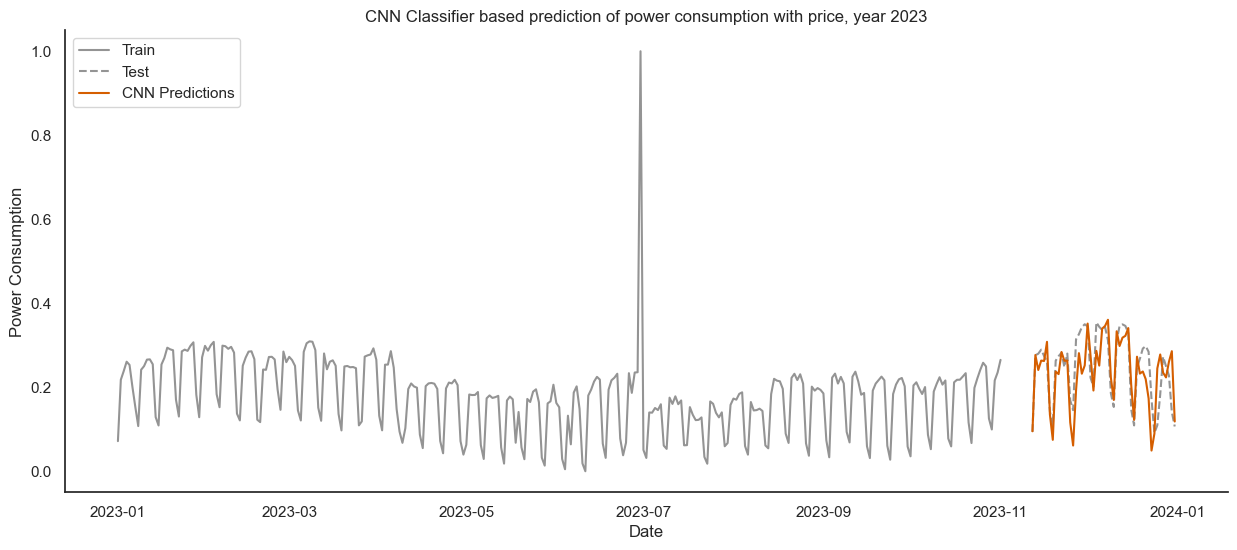

In [140]:
# Initialize Seaborn plot design
sns.set_style("white")

# Create new figure and axis
fig, ax = plt.subplots(figsize=(15,6))

# Convert y_test to pandas series
y_test_pd = pd.Series(y_test, index=test.index[look_back:])
predictions = pd.Series(predictions, index=test.index[look_back:])

# "Husl" palette
palette = sns.color_palette('colorblind')

# Plot the training data 
sns.lineplot(x=train.index, y=train.Power_Consumption, label='Train', ax=ax, color=palette[7])

# Plot the testing data 
sns.lineplot(x=y_test_pd.index, y=y_test_pd, label='Test', ax=ax, color=palette[7], linestyle="--")

# Plot the predictions
sns.lineplot(x=predictions.index, y=predictions, label='CNN Predictions', ax=ax, color=palette[3])

# Turn off the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Setting plot title and labels
ax.set_title('CNN Classifier based prediction of power consumption with price, year ' + year)
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption')

# Setting legend
ax.legend(loc='upper left')


plt.savefig('figures/CNN_prediction_'+year+'_with_price.pdf')
plt.show()
